# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services (part 2)

In [1]:
# helper functions for data laoding
from helper_functions import *

# libraries for data processing
import numpy as np
import pandas as pd

# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# sklearn packages
from sklearn import preprocessing as p
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 2.1 Extract

Extract and process data.

#### 2.1.1 Load data

In [2]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False, index_col=0)
print(mailout_train.shape)
mailout_train.head()

(42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [3]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False, index_col=0)
print(mailout_test.shape)
mailout_test.head()

(42833, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


Helper DataFrame with attribute descriptions

In [4]:
df_attr = pd.read_csv('info_attributes_processed.csv', sep=',', low_memory=False, index_col=0)
df_attr.head()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype
0,AGER_TYP,best-ager typology,"[-1, 0, 1, 2, 3]","['unknown', 'no classification possible', 'pas...",NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...,[-1],int64
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"['-1, 0', 1, 2, 3, 4, 9]","['unknown', '< 30 years', '30 - 45 years', '46...",Person,age through prename analysis,modelled on millions of first name-age-referen...,"[-1, 0]",int64
2,ALTER_HH,main age within the household,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","['unknown / no main age detectable', '01.01.18...",Household,main age within the household,NaN,[0],float64
3,ANREDE_KZ,gender,"['-1, 0', 1, 2]","['unknown', 'male', 'female']",NaN,gender,NaN,"[-1, 0]",int64
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,['…'],['numeric value (typically coded from 1-10)'],Building,number of households known in this building,NaN,[],float64


Check that both datasets have same column names.

In [5]:
train_columns = set(mailout_train.columns)
test_columns = set(mailout_test.columns)
print(train_columns.difference(test_columns))
print(test_columns.difference(train_columns))

{'RESPONSE'}
set()


`RESPONSE` column will be our `y_train` value. 

In [6]:
y_train = mailout_train["RESPONSE"]
# drop "RESPONSE" column
mailout_train = mailout_train.drop(["RESPONSE"], axis=1)

#### 2.1.3 Rename missing values

From previous project it is known that some missing values are encoded with numbers like 0 or -1. In addition, some attributes needs to be renamed to match information provided in `.xlsx` files.

In [7]:
df_dict = pd.read_csv("attribute_dict.csv", sep=',', index_col=0)
# create empty dictornary to store rename values for train and test datasets
attribute_dict = dict()
# iterate over rows
for idx in df_dict.index:
    # add keys with values to dictonary
    attribute_dict[df_dict.iloc[idx].Key] = df_dict.iloc[idx].Value
    
# check if keys attribute dictonary contains
attr_keys = set(attribute_dict.keys())
print(attr_keys.difference(test_columns))

set()


In [8]:
# create DataFrames with renmaed columns
X_train = mailout_train.rename(columns=attribute_dict)
X_test = mailout_test.rename(columns=attribute_dict)

In [9]:
%%time

# iterate over azdias columns
for col in X_test.columns:
    
    # get nan notations for that column
    nan_list = df_attr[df_attr.Attribute == col].NAN_notations.values
    # check if value is list, i.e. is not empty np.array
    if nan_list.size != 0:
        nan_list = nan_list[0]
    
    # iterate over NAN notations (if list is empty then there is no iteration)
    if len(nan_list) > 0:
        for nan_value in nan_list:
            # replace with NAN value
            X_train[col] = X_train[col].replace(nan_value, np.nan)
            X_test[col] = X_test[col].replace(nan_value, np.nan)

Wall time: 47.2 s


#### 2.1.4 Investigate missing values

Check for missing values per column.

In [10]:
# get column name array
col_names_train = X_train.columns.values
col_names_test = X_test.columns.values
# count NAN values in each collumn
nan_values_train = X_train.isna().sum().values
nan_values_test = X_test.isna().sum().values
# calculate ratio of missing values
nan_ratio_train = nan_values_train / X_train.shape[0] * 100
nan_ratio_test = nan_values_test / X_test.shape[0] * 100

Plot ratio of how much missing data is missing per column in both datasets.

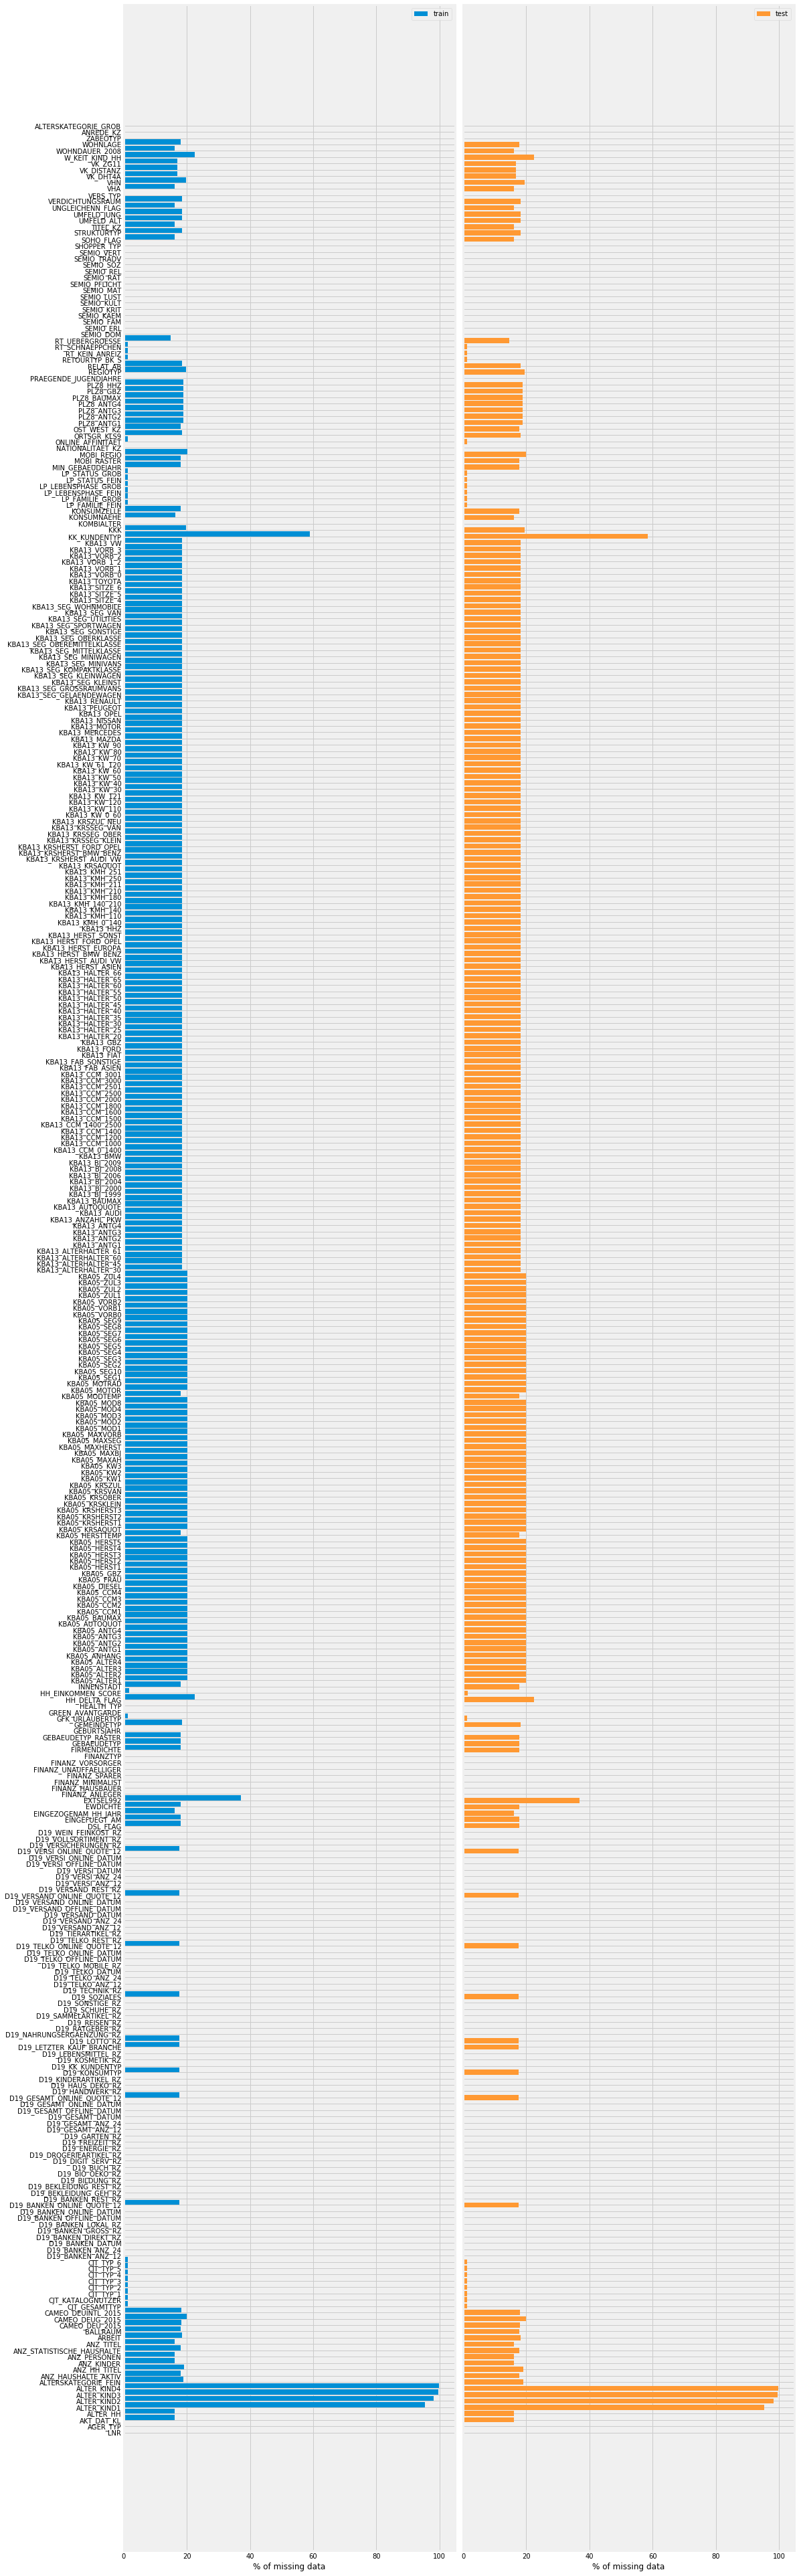

In [11]:
# create figure and axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 70), sharey='row')
# figure title
# fig.suptitle(attribute_name)

# convert x-axis to string to avoid spacing
ax1.barh(col_names_train, nan_ratio_train, align='edge', label="train")

# plot procentage difference
ax2.barh(col_names_test, nan_ratio_test, color="#ff9933", label="test")

# add legend and labels to plots
ax1.legend()
ax2.legend()
ax1.set_xlabel("% of missing data")
ax2.set_xlabel("% of missing data");
# ax1.set_ylabel("% of data")
# ax2.set_ylabel("Difference")
# create small gap between plots
plt.subplots_adjust(wspace=0.025);

Drop columns with many missing values.

In [12]:
%%time
_ = X_train.shape
print(f"Before removing columns with missing data X_train Dataframe shape: {_} \n")
X_train = remove_nan_collumns(X_train, limit=0.2)
_ = X_train.shape
print(f"\n After removing columns with missing data X_train Dataframe shape: {_}")

_ = X_test.shape
print(f"Before removing columns with missing data X_test Dataframe shape: {_} \n")
X_test = remove_nan_collumns(X_test, limit=0.2)
_ = X_test.shape
print(f"\n After removing columns with missing data X_test Dataframe shape: {_}")

Before removing columns with missing data X_train Dataframe shape: (42962, 366) 

ALTER_KIND1                    attribute removed, 95.37 % of data was missing
ALTER_KIND2                    attribute removed, 98.24 % of data was missing
ALTER_KIND3                    attribute removed, 99.59 % of data was missing
ALTER_KIND4                    attribute removed, 99.90 % of data was missing
EXTSEL992                      attribute removed, 37.12 % of data was missing
HH_DELTA_FLAG                  attribute removed, 22.53 % of data was missing
KBA05_ALTER1                   attribute removed, 20.13 % of data was missing
KBA05_ALTER2                   attribute removed, 20.13 % of data was missing
KBA05_ALTER3                   attribute removed, 20.13 % of data was missing
KBA05_ALTER4                   attribute removed, 20.13 % of data was missing
KBA05_ANHANG                   attribute removed, 20.13 % of data was missing
KBA05_ANTG1                    attribute removed, 20.13 % of

In [13]:
# check that both DataFrames have same columns
train_columns = set(X_train.columns)
test_columns = set(X_test.columns)
print(train_columns.difference(test_columns))
print(test_columns.difference(train_columns))

set()
{'KBA05_MAXBJ', 'KBA05_VORB1', 'KBA05_KW3', 'KBA05_ALTER2', 'KBA05_ALTER4', 'KBA05_CCM1', 'KBA05_MAXSEG', 'KBA05_SEG8', 'KBA05_ANTG1', 'KBA05_KRSHERST2', 'KBA05_MAXAH', 'KBA05_ZUL2', 'KBA05_AUTOQUOT', 'KBA05_HERST5', 'KBA05_MOTRAD', 'KBA05_ZUL4', 'KBA05_FRAU', 'KBA05_DIESEL', 'KBA05_KRSZUL', 'KBA05_MOD4', 'KBA05_HERST4', 'KBA05_KRSVAN', 'KBA05_HERST3', 'KBA05_CCM2', 'KBA05_ANTG3', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_ALTER1', 'KBA05_SEG1', 'KBA05_VORB0', 'KBA05_MOD1', 'KBA05_MOTOR', 'KBA05_KRSOBER', 'KBA05_BAUMAX', 'KBA05_SEG2', 'KBA05_SEG4', 'KBA05_MAXHERST', 'KBA05_ALTER3', 'KBA05_KRSAQUOT', 'KBA05_SEG3', 'KBA05_KRSKLEIN', 'KBA05_KRSHERST3', 'KBA05_ZUL1', 'KBA05_SEG9', 'KBA05_ANTG4', 'KBA05_CCM3', 'KBA05_ANHANG', 'KBA05_SEG10', 'KBA05_KW1', 'MOBI_REGIO', 'KBA05_MOD8', 'KBA05_CCM4', 'KBA05_GBZ', 'KBA05_SEG5', 'KBA05_MAXVORB', 'KBA05_HERST1', 'KBA05_ANTG2', 'KBA05_ZUL3', 'KBA05_SEG7', 'KBA05_KW2', 'KBA05_KRSHERST1', 'KBA05_SEG6', 'KBA05_HERST2', 'KBA05_VORB2'}


In [14]:
# make sure both DataFrames have same columns

X_train = X_train[list(train_columns.intersection(test_columns))]
X_test = X_test[list(train_columns.intersection(test_columns))]

Same columns in both DataFrames were removed.

#### 2.1.4 Encode numeric data

From previous project 7 columns were identified as containing numeric values: `ANZ_HAUSHALTE_AKTIV`, `ANZ_HH_TITEL`, `ANZ_PERSONEN`, `ANZ_TITEL`, `GEBURTSJAHR`, `KBA13_ANZAHL_PKW` and `MIN_GEBAEUDEJAHR`.

In [15]:
# create list for potential column names with numeric values

pot_num_col_names = list()

# first check for columns with many (more than 30) unique values
for col in X_train.columns:
    _ = X_train[col].nunique()
    if _ > 30:
        print(f"{col:30s}: {_}")
        pot_num_col_names.append(col)
        
pot_num_col_names = set(pot_num_col_names)

ANZ_STATISTISCHE_HAUSHALTE    : 173
EINGEZOGENAM_HH_JAHR          : 33
D19_LETZTER_KAUF_BRANCHE      : 35
KBA13_ANZAHL_PKW              : 1230
EINGEFUEGT_AM                 : 1599
MIN_GEBAEUDEJAHR              : 31
ANZ_HAUSHALTE_AKTIV           : 175
LNR                           : 42962
VERDICHTUNGSRAUM              : 46
GEBURTSJAHR                   : 108
LP_LEBENSPHASE_FEIN           : 41
CAMEO_DEU_2015                : 45
CAMEO_DEUINTL_2015            : 43


In [16]:
num_col_names = ["ANZ_HAUSHALTE_AKTIV", "ANZ_HH_TITEL", "ANZ_PERSONEN", "ANZ_TITEL", "GEBURTSJAHR",
                 "KBA13_ANZAHL_PKW", "MIN_GEBAEUDEJAHR"]
# convert to set
num_col_names = set(num_col_names)

# print different columns
print(num_col_names.difference(pot_num_col_names))
print(pot_num_col_names.difference(num_col_names))

{'ANZ_TITEL', 'ANZ_HH_TITEL', 'ANZ_PERSONEN'}
{'ANZ_STATISTISCHE_HAUSHALTE', 'VERDICHTUNGSRAUM', 'EINGEZOGENAM_HH_JAHR', 'LNR', 'CAMEO_DEU_2015', 'LP_LEBENSPHASE_FEIN', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEUINTL_2015', 'EINGEFUEGT_AM'}


Unknow values:

* `EINGEZOGENAM_HH_JAHR`,
* `D19_LETZTER_KAUF_BRANCHE`,
* `ANZ_STATISTISCHE_HAUSHALTE`,
* `EINGEFUEGT_AM` (datetime type object, I will remove it),
* `LNR` (from the number of unique values it seems this column contains numeric values),
* `VERDICHTUNGSRAUM`.

Known other type values:

* `LP_LEBENSPHASE_FEIN`,
* `CAMEO_DEU_2015`

In [17]:
# get list of numeric values (add to potential column names with numeric values)
num_col_names = list(num_col_names.intersection(pot_num_col_names)) + ["LNR"]
num_col_names

['ANZ_HAUSHALTE_AKTIV',
 'KBA13_ANZAHL_PKW',
 'GEBURTSJAHR',
 'MIN_GEBAEUDEJAHR',
 'LNR']

In [18]:
# drop unknow columns
X_train = X_train.drop(["EINGEZOGENAM_HH_JAHR", "D19_LETZTER_KAUF_BRANCHE",
                       "ANZ_STATISTISCHE_HAUSHALTE", "VERDICHTUNGSRAUM"], axis=1)
X_test = X_test.drop(["EINGEZOGENAM_HH_JAHR", "D19_LETZTER_KAUF_BRANCHE",
                       "ANZ_STATISTISCHE_HAUSHALTE", "VERDICHTUNGSRAUM"], axis=1)

#### 2.1.5 Encode ordinal data

Intentify columns with ordinal data using information from part 1.

In [19]:
# get ordinal data col values
ord_col_names = [_[0] for _ in pd.read_csv("ordinal_names.csv", header=None, index_col=0).values]
ord_col_names = set(ord_col_names)
# these calomn names containing ordinal names will be used later then identifying categorical data

#### 2.1.6 Encode categorical data

First encode binary categorical data.

In [20]:
bi_cat_col_names = [_[0] for _ in pd.read_csv("binary_categorical_names.csv", header=None, index_col=0).values]
bi_cat_col_names = set(bi_cat_col_names)
# drop KBA05_SEG6 from the list because it is not present in X_train and X_test DataFrames
bi_cat_col_names.remove("KBA05_SEG6")

In [21]:
# rename 2's with zeros, to have binary encoded data
X_train.loc[:, "ANREDE_KZ"] = X_train["ANREDE_KZ"].replace({2: 0})
X_train.loc[:, "VERS_TYP"] = X_train["VERS_TYP"].replace({2: 0})
X_test.loc[:, "ANREDE_KZ"] = X_test["ANREDE_KZ"].replace({2: 0})
X_test.loc[:, "VERS_TYP"] = X_test["VERS_TYP"].replace({2: 0})
# rename west 'W' with 0 and east 'O' with 1
X_train.loc[:, "OST_WEST_KZ"] = X_train["OST_WEST_KZ"].replace({'W': 0, 'O': 1})
X_test.loc[:, "OST_WEST_KZ"] = X_test["OST_WEST_KZ"].replace({'W': 0, 'O': 1})
# rename as nan value
X_train.loc[:, "VERS_TYP"] = X_train["VERS_TYP"].replace({-1: np.nan})
X_test.loc[:, "VERS_TYP"] = X_test["VERS_TYP"].replace({-1: np.nan})

In [22]:
X_train[list(bi_cat_col_names)].max()

OST_WEST_KZ         1.0
VERS_TYP            1.0
ANREDE_KZ           1.0
SOHO_FLAG           1.0
GREEN_AVANTGARDE    1.0
dtype: float64

In [23]:
X_train[list(bi_cat_col_names)].min()

OST_WEST_KZ         0.0
VERS_TYP            0.0
ANREDE_KZ           0.0
SOHO_FLAG           0.0
GREEN_AVANTGARDE    0.0
dtype: float64

All remaining columns (not numeric, not ordinal, not binary categorical data) should be one-hot encoded.

In [24]:
# mixed-type feature names (got from previous project)
mixed_col_names = ["PRAEGENDE_JUGENDJAHRE", "CAMEO_DEUINTL_2015", "LP_LEBENSPHASE_FEIN", "WOHNLAGE", "PLZ8_BAUMAX"]

# column names containing not categorical 
not_cat_col_names = list(num_col_names) + mixed_col_names + list(bi_cat_col_names) + list(ord_col_names)

# get categorical data column names
cat_col_names = set(X_train.columns).difference(set(not_cat_col_names))

In [25]:
# get only 
cat_X_train = X_train[list(cat_col_names)].copy()
cat_X_test = X_test[list(cat_col_names)].copy()

In [26]:
%%time

# iterate over columns
for col in cat_X_test.columns:
    # one-one-hot encode the feature and add it to the dataframe
    X_train = X_train.join(pd.get_dummies(cat_X_train[col], prefix=col, dummy_na=True))
    X_test = X_test.join(pd.get_dummies(cat_X_test[col], prefix=col, dummy_na=True))
    # drop feature from data
    X_train = X_train.drop([col], axis=1)
    X_test = X_test.drop([col], axis=1)
    print("{:30s} feature one-hot-encoded".format(col)) 

LP_FAMILIE_GROB                feature one-hot-encoded
RETOURTYP_BK_S                 feature one-hot-encoded
D19_BANKEN_ONLINE_DATUM        feature one-hot-encoded
D19_ENERGIE_RZ                 feature one-hot-encoded
D19_WEIN_FEINKOST_RZ           feature one-hot-encoded
D19_GESAMT_ONLINE_QUOTE_12     feature one-hot-encoded
KBA05_MODTEMP                  feature one-hot-encoded
D19_TELKO_DATUM                feature one-hot-encoded
D19_SCHUHE_RZ                  feature one-hot-encoded
ANZ_KINDER                     feature one-hot-encoded
TITEL_KZ                       feature one-hot-encoded
LP_LEBENSPHASE_GROB            feature one-hot-encoded
D19_FREIZEIT_RZ                feature one-hot-encoded
D19_VERSI_OFFLINE_DATUM        feature one-hot-encoded
D19_VERSI_ONLINE_DATUM         feature one-hot-encoded
KBA13_KMH_210                  feature one-hot-encoded
D19_VERSAND_OFFLINE_DATUM      feature one-hot-encoded
D19_BANKEN_OFFLINE_DATUM       feature one-hot-encoded
DSL_FLAG  

#### 2.1.7 Encode mixed-type features

Last 5 columns with mixed type features are manually encoded.

#### PRAEGENDE_JUGENDJAHRE

In [27]:
# replace NAN values with 0s, so that dictonary mapping could be used
# e.g. {np.nan: [np.nan, np.nan]} doesn't work.
X_train.PRAEGENDE_JUGENDJAHRE = X_train.PRAEGENDE_JUGENDJAHRE.fillna(0)
X_test.PRAEGENDE_JUGENDJAHRE = X_test.PRAEGENDE_JUGENDJAHRE.fillna(0)

# manual dictonary was created to encode diffent values to different collumn
PRAEGENDE_JUGENDJAHRE_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["40s", 0],
    2.0: ["40s", 1],
    3.0: ["50s", 0],
    4.0: ["50s", 1],
    5.0: ["60s", 0],
    6.0: ["60s", 1],
    7.0: ["60s", 1],
    8.0: ["70s", 0],
    9.0: ["70s", 1],
    10.0: ["80s", 0],
    11.0: ["80s", 1],
    12.0: ["80s", 0],
    13.0: ["80s", 1],
    14.0: ["90s", 0],
    15.0: ["90s", 1]
}

In [28]:
%%time
# create new columns for decade and movement values
_ = X_train.PRAEGENDE_JUGENDJAHRE.apply(lambda s: pd.Series({
    'PRAEGENDE_JUGENDJAHRE_decade':PRAEGENDE_JUGENDJAHRE_dict[s][0],
    'PRAEGENDE_JUGENDJAHRE_movement':PRAEGENDE_JUGENDJAHRE_dict[s][1]}))

# add these columns to data frame
X_train = X_train.merge(_, left_index=True, right_index=True)
# drop PRAEGENDE_JUGENDJAHRE column from dataframe
X_train = X_train.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1)
# one-hot-encode decade data
X_train = X_train.join(pd.get_dummies(X_train["PRAEGENDE_JUGENDJAHRE_decade"],
                                        prefix="PRAEGENDE_JUGENDJAHRE_decade"))
# drop "PRAEGENDE_JUGENDJAHRE_decade" column
X_train = X_train.drop(["PRAEGENDE_JUGENDJAHRE_decade"], axis=1)

Wall time: 24.6 s


In [29]:
%%time
# create new columns for decade and movement values
_ = X_test.PRAEGENDE_JUGENDJAHRE.apply(lambda s: pd.Series({
    'PRAEGENDE_JUGENDJAHRE_decade':PRAEGENDE_JUGENDJAHRE_dict[s][0],
    'PRAEGENDE_JUGENDJAHRE_movement':PRAEGENDE_JUGENDJAHRE_dict[s][1]}))

# add these columns to data frame
X_test = X_test.merge(_, left_index=True, right_index=True)
# drop PRAEGENDE_JUGENDJAHRE column from dataframe
X_test = X_test.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1)
# one-hot-encode decade data
X_test = X_test.join(pd.get_dummies(X_test["PRAEGENDE_JUGENDJAHRE_decade"],
                                        prefix="PRAEGENDE_JUGENDJAHRE_decade"))
# drop "PRAEGENDE_JUGENDJAHRE_decade" column
X_test = X_test.drop(["PRAEGENDE_JUGENDJAHRE_decade"], axis=1)

Wall time: 24.6 s


#### CAMEO_DEUINTL_2015

In [30]:
# convert string to numeric vlaues
X_train.loc[:, "CAMEO_DEUINTL_2015"] = X_train["CAMEO_DEUINTL_2015"].replace({"XX": 0})
X_test.loc[:, "CAMEO_DEUINTL_2015"] = X_test["CAMEO_DEUINTL_2015"].replace({"XX": 0})
X_train['CAMEO_DEUINTL_2015']= X_train['CAMEO_DEUINTL_2015'].astype(float)
X_test['CAMEO_DEUINTL_2015']= X_test['CAMEO_DEUINTL_2015'].astype(float)

In [31]:
%%time

# create new collumns for decade and movement values
_ = X_train.CAMEO_DEUINTL_2015.apply(lambda s: pd.Series({
    'CAMEO_DEUINTL_2015_wealth':s//10,
    'CAMEO_DEUINTL_2015_lifestage':s%10}))
# add these collumns to data frame
X_train = X_train.merge(_, left_index=True, right_index=True);
# drop CAMEO_INTL_2015 collumn from dataframe
X_train = X_train.drop(["CAMEO_DEUINTL_2015"], axis=1)
# one-hot-encode wealth and lifestage data
X_train = X_train.join(pd.get_dummies(X_train["CAMEO_DEUINTL_2015_wealth"],
                                        prefix="CAMEO_DEUINTL_2015_wealth"))
X_train = X_train.join(pd.get_dummies(X_train["CAMEO_DEUINTL_2015_lifestage"],
                                        prefix="CAMEO_DEUINTL_2015_lifestage"))
# drop one-hot-encoded original collumns
X_train = X_train.drop(["CAMEO_DEUINTL_2015_wealth"], axis=1)
X_train = X_train.drop(["CAMEO_DEUINTL_2015_lifestage"], axis=1)

Wall time: 24.7 s


In [32]:
%%time

# create new collumns for decade and movement values
_ = X_test.CAMEO_DEUINTL_2015.apply(lambda s: pd.Series({
    'CAMEO_DEUINTL_2015_wealth':s//10,
    'CAMEO_DEUINTL_2015_lifestage':s%10}))
# add these collumns to data frame
X_test = X_test.merge(_, left_index=True, right_index=True);
# drop CAMEO_INTL_2015 collumn from dataframe
X_test = X_test.drop(["CAMEO_DEUINTL_2015"], axis=1)
# one-hot-encode wealth and lifestage data
X_test = X_test.join(pd.get_dummies(X_test["CAMEO_DEUINTL_2015_wealth"],
                                        prefix="CAMEO_DEUINTL_2015_wealth"))
X_test = X_test.join(pd.get_dummies(X_test["CAMEO_DEUINTL_2015_lifestage"],
                                        prefix="CAMEO_DEUINTL_2015_lifestage"))
# drop one-hot-encoded original collumns
X_test = X_test.drop(["CAMEO_DEUINTL_2015_wealth"], axis=1)
X_test = X_test.drop(["CAMEO_DEUINTL_2015_lifestage"], axis=1)

Wall time: 24.7 s


#### LP_LEBENSPHASE_FEIN

In [33]:
# replace NAN values with 0s, so that dictonary mapping could be used
# e.g. {np.nan: [np.nan, np.nan, np.nan]} doesn't work.
X_train.LP_LEBENSPHASE_FEIN = X_train.LP_LEBENSPHASE_FEIN.fillna(0)
X_test.LP_LEBENSPHASE_FEIN = X_test.LP_LEBENSPHASE_FEIN.fillna(0)

# create custom dictonary to encode: social unit type, earnings and age.
LP_LEBENSPHASE_FEIN_dict = {
    0.0: [np.nan, np.nan, np.nan],
    1.0: ["single", "low", "young"],
    2.0: ["single", "low", "middle"],
    3.0: ["single", "average", "young"],
    4.0: ["single", "average", "middle"],
    5.0: ["single", "low", "advanced"],
    6.0: ["single", "low", "retirement"],
    7.0: ["single", "average", "advanced"],
    8.0: ["single", "average", "retirement"],
    9.0: ['single', "unknow", "unknow"],
    10.0: ['single_home', 'high', "unknow"],
    11.0: ['single_home', "unknow", "advanced"],
    12.0: ['single_home', "unknow", "retirement"],
    13.0: ['single', 'high', "higher"],
    14.0: ["couple", 'average', 'young'],
    15.0: ["couple", "low", 'higher'],
    16.0: ['couple', "average", "higher"],
    17.0: ['couple', "unknow", "unknow"],
    18.0: ['couple', 'high', 'young'],
    19.0: ['couple', "unknow", "higher"],
    20.0: ['couple', 'high', "higher"],
    21.0: ['single_parent', 'low', "unknow"],
    22.0: ['single_parent', 'average', "unknow"],
    23.0: ['single_parent', 'high', "unknow"],
    24.0: ['family', 'low', "unknow"],
    25.0: ['family', 'average', "unknow"],
    26.0: ['family', "unknow", "unknow"],
    27.0: ['family', "unknow", "unknow"],
    28.0: ['family', 'high', "unknow"],
    29.0: ['multi', 'low', 'young'],
    30.0: ['multi', 'average', 'young'],
    31.0: ['multi', 'low', 'higher'],
    32.0: ['multi', 'average', 'higher'],
    33.0: ['multi', "unknow" , 'young'],
    34.0: ['multi', "unknow", 'young'],
    35.0: ['multi', 'high' , 'young'],
    36.0: ['multi', "unknow" , 'higher'],
    37.0: ['multi', "unknow" , 'advanced'],
    38.0: ['multi', "unknow" , 'retirement'],
    39.0: ['multi', 'high' , 'middle'],
    40.0: ['multi', 'high' , 'retirement']    
}

In [34]:
%%time
# create new collumns for decade and movement values
_ = X_train.LP_LEBENSPHASE_FEIN.apply(lambda s: pd.Series({
    'LP_LEBENSPHASE_FEIN_type':LP_LEBENSPHASE_FEIN_dict[s][0],
    'LP_LEBENSPHASE_FEIN_income':LP_LEBENSPHASE_FEIN_dict[s][1],
    'LP_LEBENSPHASE_FEIN_age':LP_LEBENSPHASE_FEIN_dict[s][2]}))
# add these collumns to data frame
X_train = X_train.merge(_, left_index=True, right_index=True);
# drop LP_LEBENSPHASE_FEIN collumn from dataframe
X_train = X_train.drop(["LP_LEBENSPHASE_FEIN"], axis=1)

# one-hot-encode type, income and age data
X_train = X_train.join(pd.get_dummies(X_train["LP_LEBENSPHASE_FEIN_type"],
                                        prefix="LP_LEBENSPHASE_FEIN_type"))
X_train = X_train.join(pd.get_dummies(X_train["LP_LEBENSPHASE_FEIN_income"],
                                        prefix="LP_LEBENSPHASE_FEIN_income"))
X_train = X_train.join(pd.get_dummies(X_train["LP_LEBENSPHASE_FEIN_age"],
                                        prefix="LP_LEBENSPHASE_FEIN_age"))

# drop one-hot-encoded original collumns
X_train = X_train.drop(["LP_LEBENSPHASE_FEIN_type"], axis=1)
X_train = X_train.drop(["LP_LEBENSPHASE_FEIN_income"], axis=1)
X_train = X_train.drop(["LP_LEBENSPHASE_FEIN_age"], axis=1)

Wall time: 25.4 s


In [35]:
%%time
# create new collumns for decade and movement values
_ = X_test.LP_LEBENSPHASE_FEIN.apply(lambda s: pd.Series({
    'LP_LEBENSPHASE_FEIN_type':LP_LEBENSPHASE_FEIN_dict[s][0],
    'LP_LEBENSPHASE_FEIN_income':LP_LEBENSPHASE_FEIN_dict[s][1],
    'LP_LEBENSPHASE_FEIN_age':LP_LEBENSPHASE_FEIN_dict[s][2]}))
# add these collumns to data frame
X_test = X_test.merge(_, left_index=True, right_index=True);
# drop LP_LEBENSPHASE_FEIN collumn from dataframe
X_test = X_test.drop(["LP_LEBENSPHASE_FEIN"], axis=1)

# one-hot-encode type, income and age data
X_test = X_test.join(pd.get_dummies(X_test["LP_LEBENSPHASE_FEIN_type"],
                                        prefix="LP_LEBENSPHASE_FEIN_type"))
X_test = X_test.join(pd.get_dummies(X_test["LP_LEBENSPHASE_FEIN_income"],
                                        prefix="LP_LEBENSPHASE_FEIN_income"))
X_test = X_test.join(pd.get_dummies(X_test["LP_LEBENSPHASE_FEIN_age"],
                                        prefix="LP_LEBENSPHASE_FEIN_age"))

# drop one-hot-encoded original collumns
X_test = X_test.drop(["LP_LEBENSPHASE_FEIN_type"], axis=1)
X_test = X_test.drop(["LP_LEBENSPHASE_FEIN_income"], axis=1)
X_test = X_test.drop(["LP_LEBENSPHASE_FEIN_age"], axis=1)

Wall time: 25.8 s


#### WOHNLAGE

In [36]:
# replace NAN values with 0s, so that dictonary mapping could be used
# e.g. {np.nan: [np.nan, np.nan]} doesn't work.
X_train.WOHNLAGE = X_train.WOHNLAGE.fillna(0)
X_test.WOHNLAGE = X_test.WOHNLAGE.fillna(0)

# create custom dictonary for WOHNLANGE feature
WOHNLAGE_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["very good", 0],
    2.0: ["good", 0],
    3.0: ["average", 0],
    4.0: ["poor", 0],
    5.0: ["very poor", 0],
    7.0: ["unknown", 1],
    8.0: ["new building", 1]
}

In [37]:
%%time
# create new collumns for decade and movement values
_ = X_train.WOHNLAGE.apply(lambda s: pd.Series({
    'WOHNLAGE_score':WOHNLAGE_dict[s][0],
    'WOHNLAGE_score_rular':WOHNLAGE_dict[s][1]}))
# add these collumns to data frame
X_train = X_train.merge(_, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
X_train = X_train.drop(["WOHNLAGE"], axis=1)

# one-hot encode score
X_train = X_train.join(pd.get_dummies(X_train["WOHNLAGE_score"],
                                        prefix="WOHNLAGE_score"))

# drop one-hot-encoded original collumns
X_train = X_train.drop(["WOHNLAGE_score"], axis=1)

Wall time: 24.9 s


In [38]:
%%time
# create new collumns for decade and movement values
_ = X_test.WOHNLAGE.apply(lambda s: pd.Series({
    'WOHNLAGE_score':WOHNLAGE_dict[s][0],
    'WOHNLAGE_score_rular':WOHNLAGE_dict[s][1]}))
# add these collumns to data frame
X_test = X_test.merge(_, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
X_test = X_test.drop(["WOHNLAGE"], axis=1)

# one-hot encode score
X_test = X_test.join(pd.get_dummies(X_test["WOHNLAGE_score"],
                                        prefix="WOHNLAGE_score"))

# drop one-hot-encoded original collumns
X_test = X_test.drop(["WOHNLAGE_score"], axis=1)

Wall time: 24.7 s


#### PLZ8_BAUMAX

In [39]:
# replace NAN values with 0s, so that dictonary mapping could be used
# e.g. {np.nan: [np.nan, np.nan]} doesn't work.
X_train.PLZ8_BAUMAX = X_train.PLZ8_BAUMAX.fillna(0)
X_test.PLZ8_BAUMAX = X_test.PLZ8_BAUMAX.fillna(0)

# create custom dictonary for WOHNLANGE feature
PLZ8_BAUMAX_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["1-2", 0],
    2.0: ["3-5", 0],
    3.0: ["6-10", 0],
    4.0: ["10+", 0],
    5.0: ["unknown", 1]
}

In [40]:
%%time
# create new collumns for decade and movement values
_ = X_train.PLZ8_BAUMAX.apply(lambda s: pd.Series({
    'PLZ8_BAUMAX_size':PLZ8_BAUMAX_dict[s][0],
    'PLZ8_BAUMAX_cell_type':PLZ8_BAUMAX_dict[s][1]}))
# add these collumns to data frame
X_train = X_train.merge(_, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
X_train = X_train.drop(["PLZ8_BAUMAX"], axis=1);

# one-hot encode size
X_train = X_train.join(pd.get_dummies(X_train["PLZ8_BAUMAX_size"], prefix="PLZ8_BAUMAX_size"))

# drop one-hot-encoded original collumns
X_train = X_train.drop(["PLZ8_BAUMAX_size"], axis=1)

Wall time: 24.7 s


In [41]:
%%time
# create new collumns for decade and movement values
_ = X_test.PLZ8_BAUMAX.apply(lambda s: pd.Series({
    'PLZ8_BAUMAX_size':PLZ8_BAUMAX_dict[s][0],
    'PLZ8_BAUMAX_cell_type':PLZ8_BAUMAX_dict[s][1]}))
# add these collumns to data frame
X_test = X_test.merge(_, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
X_test = X_test.drop(["PLZ8_BAUMAX"], axis=1);

# one-hot encode size
X_test = X_test.join(pd.get_dummies(X_test["PLZ8_BAUMAX_size"], prefix="PLZ8_BAUMAX_size"))

# drop one-hot-encoded original collumns
X_test = X_test.drop(["PLZ8_BAUMAX_size"], axis=1)

Wall time: 25.2 s


### 2.2 Transform

Transform data for supervised learning.

#### 2.2.1 Check remaining missing data entries

In [ ]:
%%time

# total missing data in processed DataFrame
total_nan = X_train.isna().sum().sum()
total = X_train.shape[0] * X_train.shape[1]
print("Total misssing data {:.3f}% from X_train DataFrame".format(total_nan/total*100))
# total missing data in processed DataFrame
total_nan = X_test.isna().sum().sum()
total = X_test.shape[0] * X_test.shape[1]
print("Total misssing data {:.3f}% from X_test DataFrame".format(total_nan/total*100))

Because less than 1% of data is missing, I decided to simply impute missing values with averages for aprticular column.

In [ ]:
# fill NAN values with average

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_values = imp.fit_transform(X_train)
test_values = imp.fit_transform(X_test)

In [ ]:
X_train.columns

In [ ]:
%%time

# total missing data in processed DataFrame
total_nan = X_train.isna().sum().sum()
total = X_train.shape[0] * X_train.shape[1]
print("Total misssing data {:.3f}% from X_train DataFrame".format(total_nan/total*100))
# total missing data in processed DataFrame
total_nan = X_test.isna().sum().sum()
total = X_test.shape[0] * X_test.shape[1]
print("Total misssing data {:.3f}% from X_test DataFrame".format(total_nan/total*100))

In [ ]:
# manually impute all missing values with mean value
_ = X_train.isna().sum()
_ = _[_>0]

for idx in _.index:
    _mean = X_train[idx].mean()
    X_train[idx] = X_train[idx].fillna(_mean)

In [ ]:
%%time



In [ ]:
X_train['LNR']

Drop rows containing missing data entries.

In [ ]:
%%time
# remove all rows which contain atleast one nan value

total = X_train.shape[0]
# drop NAN values and re-save
X_train = X_train.dropna()
total_no_nan = X_train.shape[0]
proc = total_no_nan/total*100
print("{:.2f}% of data left after dropping all rows which contain atleast one NAN value".format(proc))


total = X_test.shape[0]
# drop NAN values and re-save
X_test = X_test.dropna()
total_no_nan = X_test.shape[0]
proc = total_no_nan/total*100
print("{:.2f}% of data left after dropping all rows which contain atleast one NAN value".format(proc))

Check that both DataFrames contain same columns.

In [ ]:
set_1 = set(X_train.columns)
set_2 = set(X_test.columns)
set_1.difference(set_2)

In [ ]:
set_2.difference(set_1)